In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from timezonefinder import TimezoneFinder
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import random

# set cwd to src
os.chdir('../src')
from utils import normal

## Load Data

In [83]:
X = pd.read_csv('../results/csvs/training_data.csv')
y = pd.read_csv('../data/IrvineSpectrumCenter_parking_2022-11_to_2023-03.csv')
lot_ids = list(X['pk_lot'].unique())
y = y[y['pk_lot'].isin(lot_ids)]

# remove the -8:00 from the end of the timestamp. I didn't mean to add it in the first place
# X['timestamp'] = X['timestamp'].apply(lambda x: x[:-6])
# X['timestamp'] = pd.to_datetime(X['timestamp'])
# X['timestamp'] = X['timestamp'].dt.tz_localize('UTC')

# convert timestamp to datetime when the rows have different timezones
X['timestamp'] = pd.to_datetime(X['timestamp'])
X['hour'] = X['timestamp'].dt.hour
X['day_of_week'] = X['timestamp'].dt.dayofweek
min_time = X['timestamp'].min()
max_time = X['timestamp'].max()

y['timestamp'] = pd.to_datetime(y['dt_start_date'])
y['timestamp'] = y['timestamp'].apply(lambda x: x.replace(microsecond=0))
y['timestamp'] = y['timestamp'].dt.tz_convert('US/Pacific')
y.drop(columns=['dt_start_date', 'dt_end_date', 'pk_lot_alias', 'f_occupancy_rank'], inplace=True)
y = y[(y['timestamp'] >= min_time) & (y['timestamp'] <= max_time)]

X = X.sort_values(by=['timestamp'])
y = y.sort_values(by=['timestamp'])
display(X.head(2))
display(y.head(2))
print('X shape:', X.shape)
print('y shape:', y.shape)

,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,long_hotspot,long_wasserstein,long_log_prob,long_hunting_time,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week
0,0.326132,1.371742,12.619595,61.0,0.049342,0.326132,1.327929,12.619595,61.0,0.022556,0.326132,1.202565,12.619595,61.0,0.005263,381381,2022-12-31 16:15:59-08:00,16,5
1,0.349622,1.409490,12.516190,42.0,0.098684,0.337877,1.172385,12.567893,51.5,0.045113,0.337877,1.279751,12.567893,51.5,0.010526,381381,2022-12-31 16:16:35-08:00,16,5


,i_avail,i_occ,f_pct_occ,pk_lot,location,geometry,timestamp
21366,44,NaN,78.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -...",2022-12-31 16:23:15-08:00
21367,677,NaN,53.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -...",2022-12-31 16:23:16-08:00


X shape: (1393, 19)
y shape: (1350, 7)


Confirm we have temporal coverage

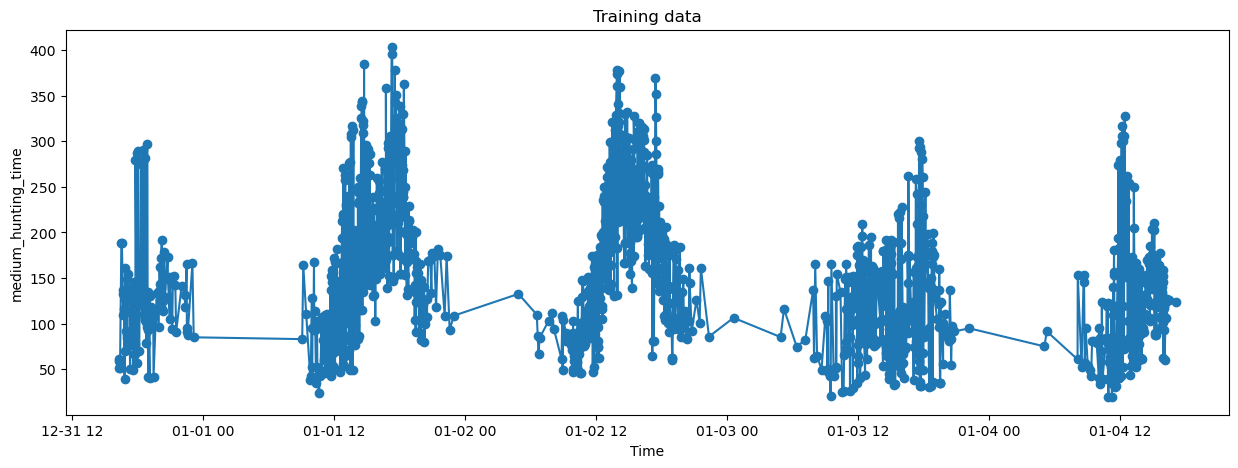

In [84]:
att = 'medium_hunting_time'
plt.figure(figsize=(15, 5))
plt.plot(X['timestamp'], X[att], marker='o')
plt.xlabel('Time')
plt.ylabel(att)
plt.title('Training data')
plt.show()

For each row of X, let it inherit the ground truth value from the row in y with the same parking lot and nearest timestamp

In [85]:
y = y[['timestamp', 'pk_lot', 'f_pct_occ', 'i_avail']]

In [86]:
merged_df = X.merge(y, on='pk_lot', suffixes=('', '_y'))

merged_df['time_diff'] = (merged_df['timestamp'] - merged_df['timestamp_y']).dt.total_seconds().abs()
df = merged_df.sort_values(by=['pk_lot', 'timestamp', 'time_diff']).drop_duplicates(subset=['pk_lot', 'timestamp'], keep='first')
df = df.drop(columns=['timestamp_y', 'time_diff'])
display(df.head(2))
print('df shape:', df.shape)

,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,...,long_wasserstein,long_log_prob,long_hunting_time,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week,f_pct_occ,i_avail
900,0.165336,1.400189,12.335927,189.0,0.197368,0.165336,1.407322,12.335927,189.0,0.052632,...,1.410554,12.335927,189.0,0.020776,329825,2022-12-31 16:29:35-08:00,16,5,77.0,56
1125,0.165336,1.340297,12.335927,189.0,0.157895,0.165336,1.412769,12.335927,189.0,0.049342,...,1.365641,12.335927,189.0,0.020243,329825,2022-12-31 16:32:29-08:00,16,5,77.0,56


df shape: (1392, 21)


,pk_lot,hour,day_of_week,typical_f_pct_occ,hour_of_week
0,329825,6,0,22.000,6
3,329825,9,0,29.000,9
7,329825,10,0,55.800,10
11,329825,11,0,75.500,11
15,329825,12,0,80.000,12
...,...,...,...,...,...
294,387459,15,6,62.000,159
298,387459,16,6,63.250,160
302,387459,17,6,64.375,161
305,387459,18,6,62.000,162


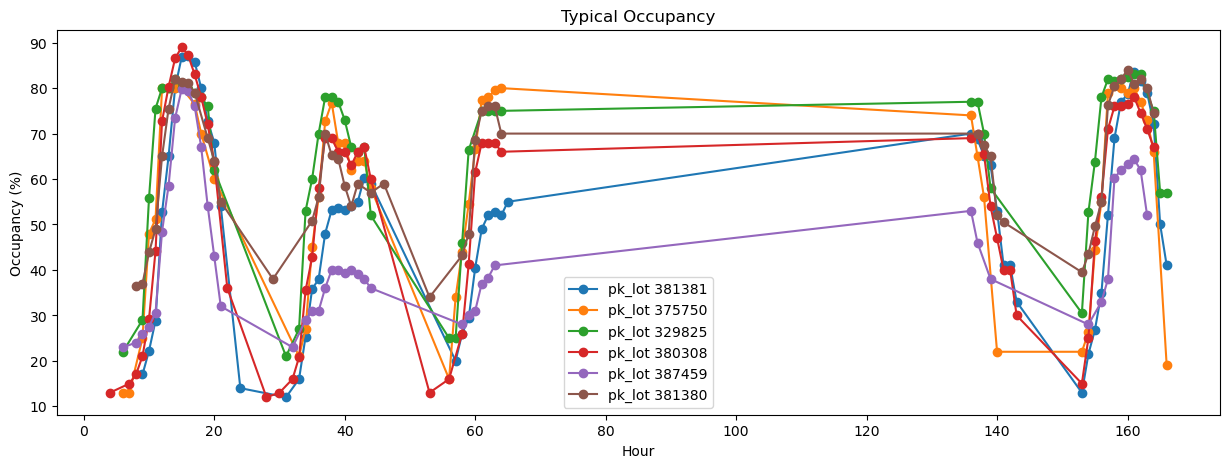

In [87]:
# typical occupancy for each (lot, hour, day_of_week) tuple
typical_occupancy = df.groupby(['pk_lot', 'hour', 'day_of_week'])['f_pct_occ'].mean().reset_index()
typical_occupancy['hour_of_week'] = typical_occupancy['day_of_week'] * 24 + typical_occupancy['hour']
typical_occupancy = typical_occupancy.sort_values(by=['pk_lot', 'hour_of_week'])
typical_occupancy = typical_occupancy.rename(columns={'f_pct_occ': 'typical_f_pct_occ'})
display(typical_occupancy)

# make a plot of each lot's typical occupancy
plt.figure(figsize=(15, 5))
for lot_id in lot_ids:
    lot_df = typical_occupancy[typical_occupancy['pk_lot'] == lot_id]
    plt.plot(lot_df['hour_of_week'], lot_df['typical_f_pct_occ'], label=f'pk_lot {lot_id}', marker='o')
plt.xlabel('Hour')
plt.ylabel('Occupancy (%)')
plt.title('Typical Occupancy')
plt.legend()
plt.show()

## Analyze the Residuals

Merge the typical occupancy to the df

In [88]:
orig_size = df.shape[0]
df = pd.merge(df, typical_occupancy, on=['pk_lot', 'hour', 'day_of_week'], how='inner')
assert orig_size == df.shape[0]
df['delta'] = df['f_pct_occ'] - df['typical_f_pct_occ']
display(df.head(5))
# this doesn't do anything when you have less than a week of data

,short_hotspot,short_wasserstein,short_log_prob,short_hunting_time,short_in_out_ratio,medium_hotspot,medium_wasserstein,medium_log_prob,medium_hunting_time,medium_in_out_ratio,...,long_in_out_ratio,pk_lot,timestamp,hour,day_of_week,f_pct_occ,i_avail,typical_f_pct_occ,hour_of_week,delta
0,0.165336,1.400189,12.335927,189.0,0.197368,0.165336,1.407322,12.335927,189.000000,0.052632,...,0.020776,329825,2022-12-31 16:29:35-08:00,16,5,77.0,56,77.0,136,0.0
1,0.165336,1.340297,12.335927,189.0,0.157895,0.165336,1.412769,12.335927,189.000000,0.049342,...,0.020243,329825,2022-12-31 16:32:29-08:00,16,5,77.0,56,77.0,136,0.0
2,0.137400,1.689747,11.701389,14.0,0.473684,0.135543,1.194820,11.921746,109.652667,0.148026,...,0.060729,329825,2022-12-31 16:40:36-08:00,16,5,77.0,56,77.0,136,0.0
3,0.181835,1.566702,12.217297,6.0,1.578947,0.147116,1.000651,11.995634,83.739500,0.197368,...,0.080972,329825,2022-12-31 16:58:53-08:00,16,5,77.0,56,77.0,136,0.0
4,0.208481,2.050361,12.522885,48.0,1.973684,0.159389,0.680936,12.101084,76.591600,0.246711,...,0.098684,329825,2022-12-31 17:15:22-08:00,17,5,77.0,55,77.0,137,0.0


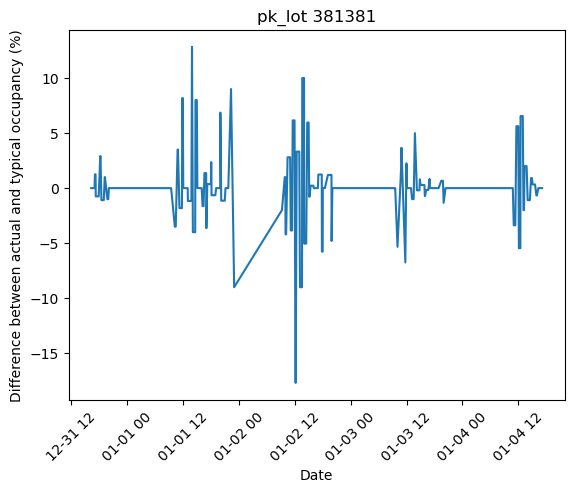

In [89]:
# plot the delta vs. timestamp for first week for random lot
lot_id = np.random.choice(lot_ids)
start_date = '2022-11-01'
end_date = '2023-03-31'
week_df = df[(df['timestamp'] > start_date) & (df['timestamp'] < end_date) & (df['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['delta'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Difference between actual and typical occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

Plot distribution of deltas

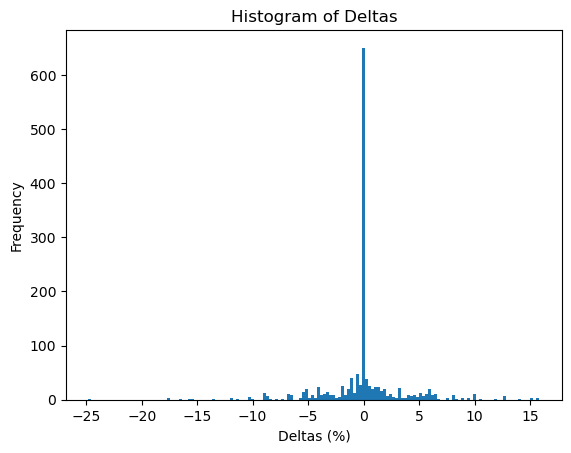

In [90]:
bins = 150
plt.hist(df['delta'], bins=bins)
plt.xlabel('Deltas (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Deltas')
plt.show()

If it was normal...

Mean: 7.656710514656252e-18
Standard Deviation: 3.6784634528554045


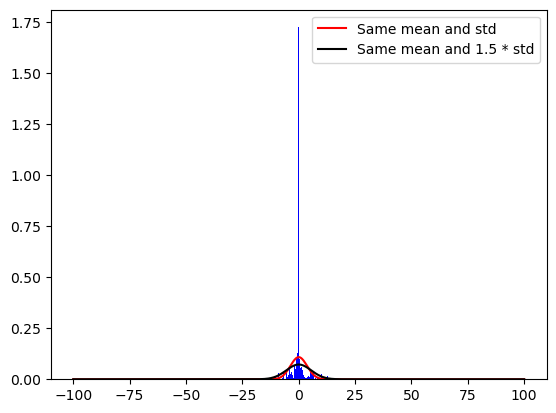

In [91]:
mean = df['delta'].mean()
std = df['delta'].std()
print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')

# plot a normal distribution with the same mean and new standard deviation
x = np.linspace(-100, 100, 1000)
y = normal(x, mean, std)
plt.plot(x, y, color='red', label='Same mean and std')

std_multiplier = 1.5
new_std = std * std_multiplier
x = np.linspace(-100, 100, 1000)
y = (1 / (new_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / new_std) ** 2)
plt.plot(x, y, color='black', label=f'Same mean and {std_multiplier} * std')

# plot the histogram of deltas
plt.hist(df['delta'], bins=bins, density=True, color='b')
plt.legend()
plt.show()

Resample to make deltas normal

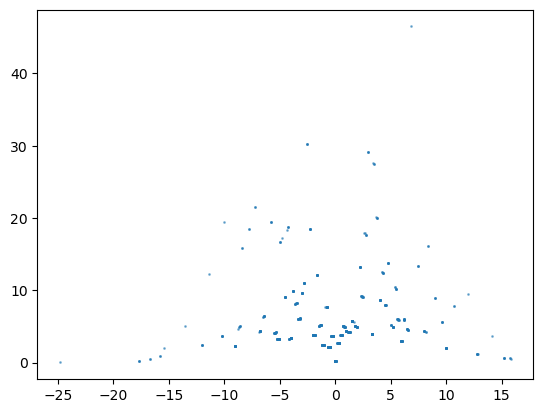

In [92]:
dframe = df.copy()
# given a delta value, how many rows are in the same bin as it?
dframe['bin'] = pd.cut(dframe['delta'], bins=bins, labels=False)
bin_counts = dframe['bin'].value_counts(normalize=True).reset_index()
bin_counts.columns = ['bin', 'bin_percent']

# join the bin_percent to dframe
dframe = pd.merge(dframe, bin_counts, on='bin', how='inner')
# normal distribution
dframe['weight'] = normal(dframe['delta'].values, mean, new_std) / dframe['bin_percent'].values
# uniform  distribution
# dframe['weight'] = 1 / dframe['bin_percent'].values

plt.scatter(dframe['delta'], dframe['weight'], s=1, alpha = 0.5)
plt.show()

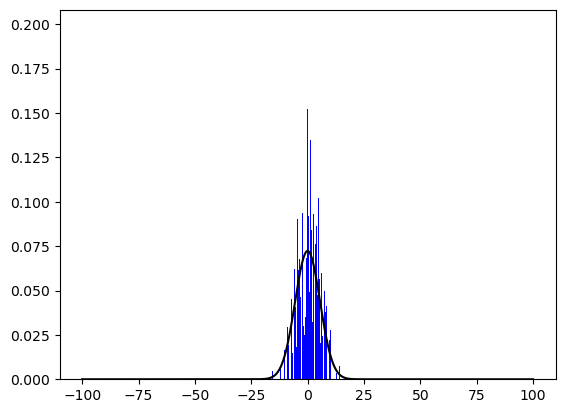

In [93]:
resamp = dframe.copy()
multiplier = 5
resamp = resamp.sample(n=multiplier * dframe.shape[0], replace=True, weights=resamp['weight'])
resamp = resamp.drop(columns=['bin', 'bin_percent', 'weight'])

# plot the histogram of deltas
plt.hist(resamp['delta'], bins=bins, density=True, color='b')
# plt.show()

# plot a normal distribution with the same mean and standard deviation
x = np.linspace(-100, 100, 1000)
y = normal(x, mean, new_std)
plt.plot(x, y, color='black')
plt.show()

## Feature Validation

In [95]:
print(X.columns)

Index(['short_hotspot', 'short_wasserstein', 'short_log_prob',
       'short_hunting_time', 'short_in_out_ratio', 'medium_hotspot',
       'medium_wasserstein', 'medium_log_prob', 'medium_hunting_time',
       'medium_in_out_ratio', 'long_hotspot', 'long_wasserstein',
       'long_log_prob', 'long_hunting_time', 'long_in_out_ratio', 'pk_lot',
       'timestamp', 'hour', 'day_of_week'],
      dtype='object')


Old size: 228, New size: 228


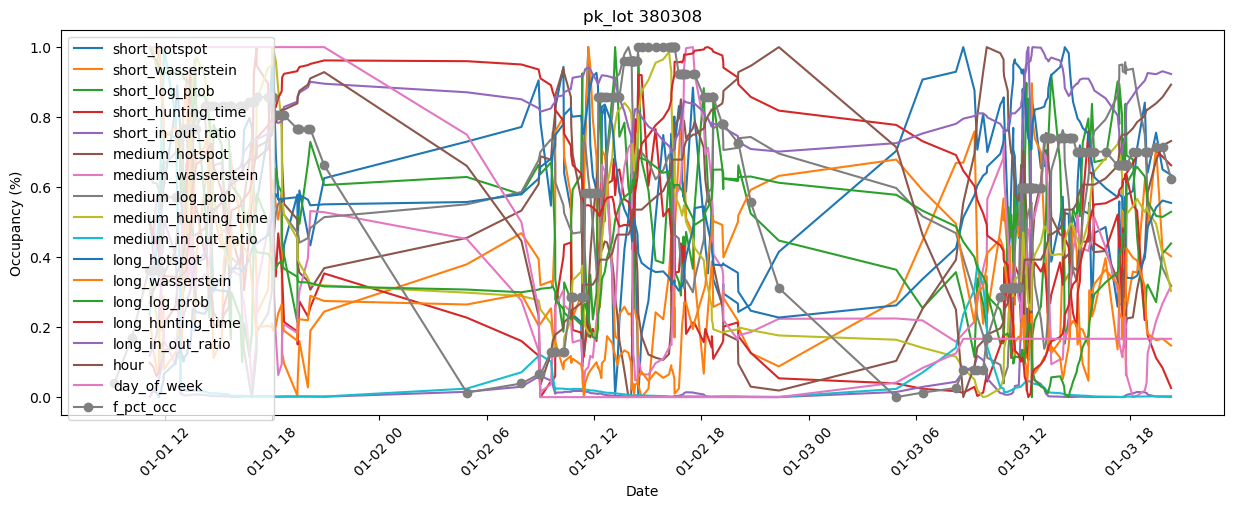

In [96]:
# plot the normalized input features with the output features over time
input_features = ['short_hotspot', 'short_wasserstein', 'short_log_prob',
       'short_hunting_time', 'short_in_out_ratio', 'medium_hotspot',
       'medium_wasserstein', 'medium_log_prob', 'medium_hunting_time',
       'medium_in_out_ratio', 'long_hotspot', 'long_wasserstein',
       'long_log_prob', 'long_hunting_time', 'long_in_out_ratio',
       'hour', 'day_of_week']
output_feature = 'f_pct_occ'
lot_id = np.random.choice(lot_ids)
# pick a random start date
start_month = 1
start_date = 1
end_date = 4
start_date = f'2023-0{start_month}-{start_date}'
end_date = f'2023-0{start_month}-{end_date}'
week_df = df[(df['timestamp'] > start_date) & (df['timestamp'] < end_date) & (df['pk_lot'] == lot_id)].copy()
# drop all duplicates except 1
orig_size = week_df.shape[0]
week_df = week_df.drop_duplicates(subset=['timestamp'], keep='first')
week_df = week_df.sort_values(by=['timestamp'])
new_size = week_df.shape[0]
print(f'Old size: {orig_size}, New size: {new_size}')

# apply smoothing to some features
for feat in input_features:
    week_df[feat] = week_df[feat].rolling(window=4).mean()


plt.figure(figsize=(15, 5))
feats = input_features + [output_feature]
for feat in feats:
    data = (week_df[feat].values - week_df[feat].min()) / (week_df[feat].max() - week_df[feat].min())
    if feat == output_feature:
        plt.plot(week_df['timestamp'], data, marker='o', label=feat)
    else:
        plt.plot(week_df['timestamp'], data, label=feat)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()